# Script for generating trait + population graphs
Plots each species in one simulation on the same graph (for comparison between species)
Prints each trait from all simulations next to each other (for comparison between different simulations)

In [1]:
export = True
graphTraits = True
graphRounds = True
matrixFCM = False

In [2]:
# basic imports and reading of file
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from pathlib import Path
import glob
import time
import json
import seaborn as sns

In [3]:
# load logs
traits = []
dataframes = []

fcms = []
fcm_dataframes = dict()

fcmGraphs = []
fcmGraphFrames = dict()

roundStats = []
roundFrames = []

actionStats = []
actionFrames = dict()

subFolders = glob.glob("Logs/*/")
for sub in subFolders:
    traits = traits + glob.glob(sub +"Traits.txt")
    fcms = fcms + glob.glob(sub + "*_fcm.txt")
    fcmGraphs = fcmGraphs + glob.glob(sub + "*_fcmGraph.txt")
    roundStats = roundStats + glob.glob(sub + "RoundSummary.txt")
    actionStats += glob.glob(sub + "*ActionSummary.txt")
for file in traits:
    dataframes.append((pd.read_csv(file), file.split('\\')[1]))

for file in fcms:
    graph_name = file.split('\\')[1]
    specie = file.split('\\')[2].split('_fcm.')[0].split(' ')[2]
    round = file.split('\\')[2].split('_fcm.')[0].split(' ')[1]
    csv = pd.read_csv(file)
    
    _tuple = (pd.read_csv(file), round)
    
    if specie not in fcm_dataframes:
        fcm_dataframes[specie] = dict()
    if graph_name not in fcm_dataframes[specie]:
        fcm_dataframes[specie][graph_name] = dict()      
    fcm_dataframes[specie][graph_name][int(round)] = pd.read_csv(file)
    
for file in fcmGraphs:
    graph_name = file.split('\\')[1]
    specie = file.split('\\')[2].split('_fcmGraph.')[0]
    csv = pd.read_csv(file)
    tuple = (csv, graph_name)
    
    if specie not in fcmGraphFrames:
        fcmGraphFrames[specie] = []    
    fcmGraphFrames[specie].append(tuple)
    
for file in roundStats:
    roundFrames.append((pd.read_csv(file), file.split('\\')[1]))
    
    
for file in actionStats:
    graph_name = file.split('\\')[1]
    specie = file.split('\\')[2].split('_ActionSummary.txt')[0]
    csv = pd.read_csv(file)
    tuple = (csv, graph_name)
    
    if specie not in actionFrames:
        actionFrames[specie] = []    
    actionFrames[specie].append(tuple)


In [4]:
# see what species and traits exist
species = set()
traits = set()
for df in dataframes:
    for col in df[0].columns:
        species.add(col.split('-')[0])
        traits.add(col.split('-')[1])

In [5]:
# make export folder
if export:
    folder="Graphs/" + time.strftime("%m-%d--%H-%M-%S")
    Path(folder).mkdir(parents=True, exist_ok=True)
    fcmFolder = folder + "/fcms"
    Path(fcmFolder).mkdir(parents=True, exist_ok=True)
    fcmGraphFolder = folder + "/fcmGraphs"
    Path(fcmGraphFolder).mkdir(parents=True, exist_ok=True)
    roundFolder = folder + "/rounds"
    Path(roundFolder).mkdir(parents=True, exist_ok=True)
    actionFolder = folder + "/actionSummary"
    Path(actionFolder).mkdir(parents=True, exist_ok=True)

In [6]:
if (matrixFCM):
    # plot fcm
    for s in species: 
        for simulation in fcm_dataframes[s]:
            roundsLeft = True
            round = 0
            while (roundsLeft):
                if round in fcm_dataframes[s][simulation]:
        #for fcm in fcm_dataframes[s]: 
                    fig, axes = plt.subplots(figsize = (12, 6))
                    #read csv
                    data = fcm_dataframes[s][simulation][round]
                    #Make it display the fields in the same way as they are listed in EntityField
                    data['from'] = pd.Categorical(data['from'], data['from'].unique())
                    data['to'] = pd.Categorical(data['to'], data['to'].unique())


                    data = data.pivot('from', 'to', 'weight')
                    ax = sns.heatmap(data,center=0, linewidth=1, annot=False, cmap="coolwarm")#,vmin=-1, vmax=1)
                    plot_title = s + " " + simulation + " round " + str(round)
                    ax.set_title(plot_title)
                    ax.set_ylabel('')
                    ax.set_xlabel('')
                    # fix for mpl bug that cuts off top/bottom of seaborn viz
                    b, t = ax.get_ylim() # discover the values for bottom and top
                    b += 0.5 # Add 0.5 to the bottom
                    t -= 0.5 # Subtract 0.5 from the top
                    ax.set_ylim([b,t]) # update the ylim(bottom, top) values

                    if export:
                        fig.savefig(fcmFolder + "/" + plot_title, bbox_inches = 'tight')

                    round = round + 1
                else:
                    roundsLeft = False;

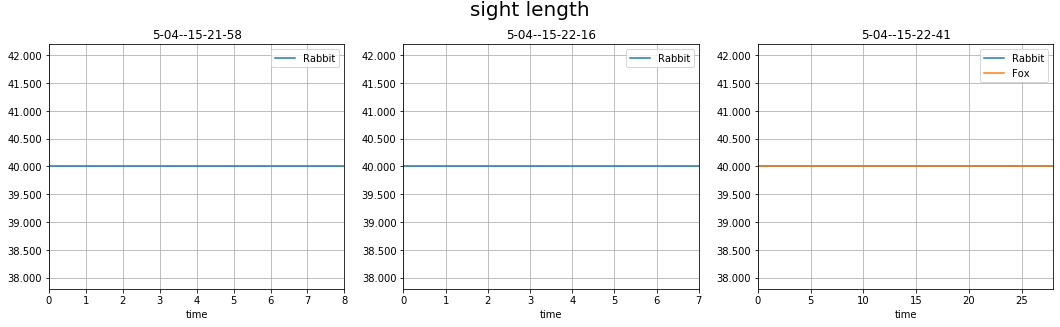

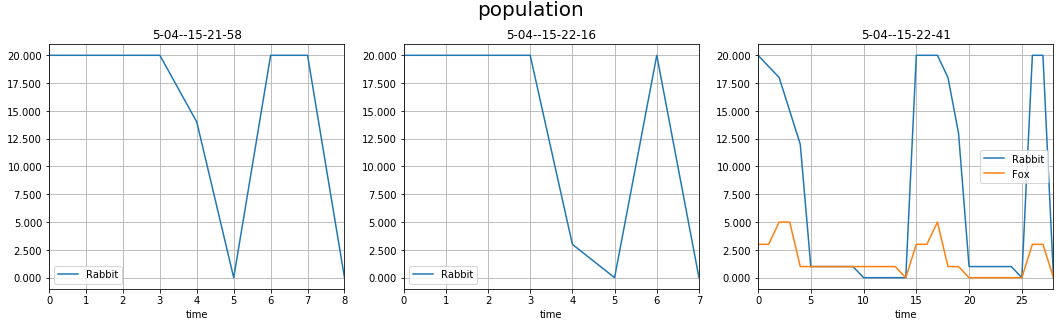

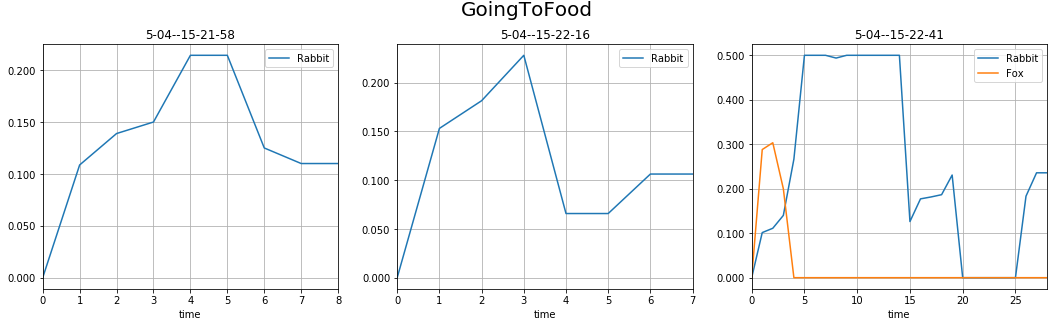

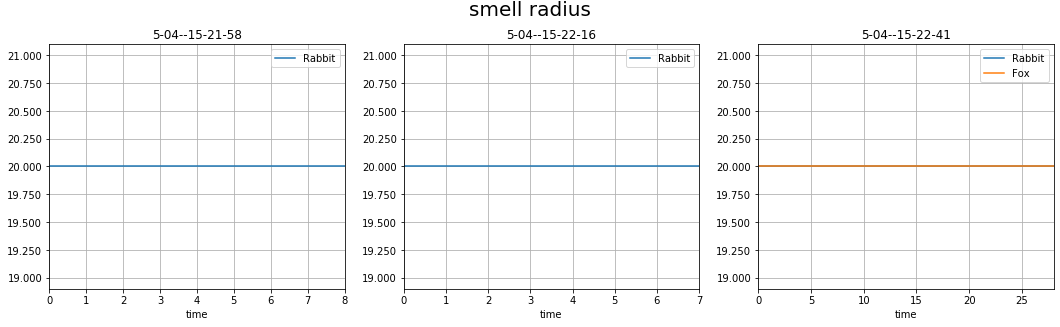

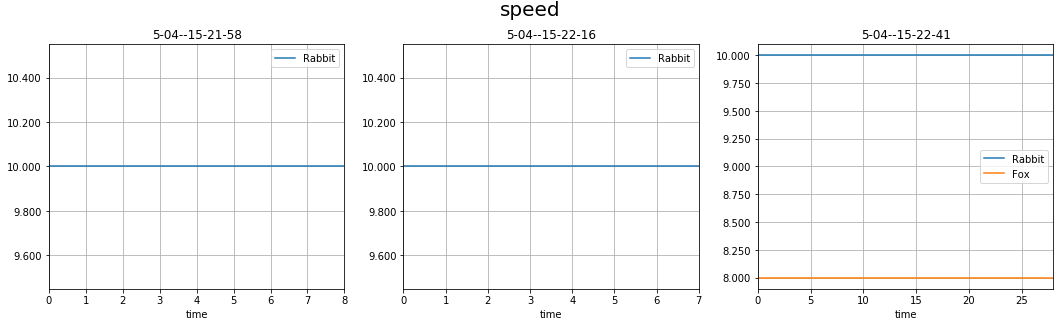

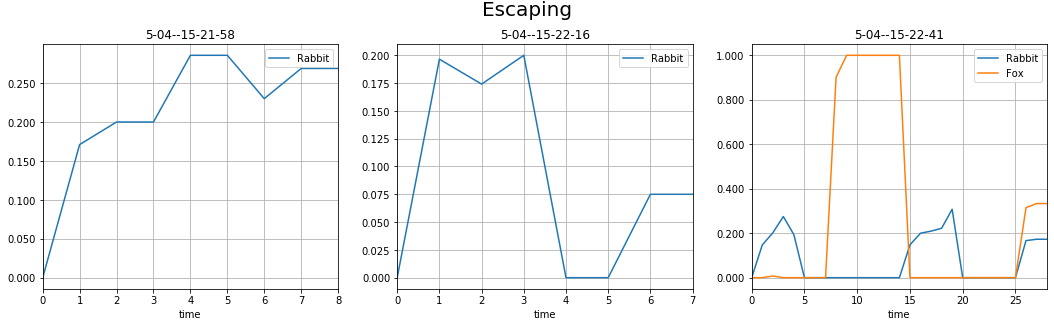

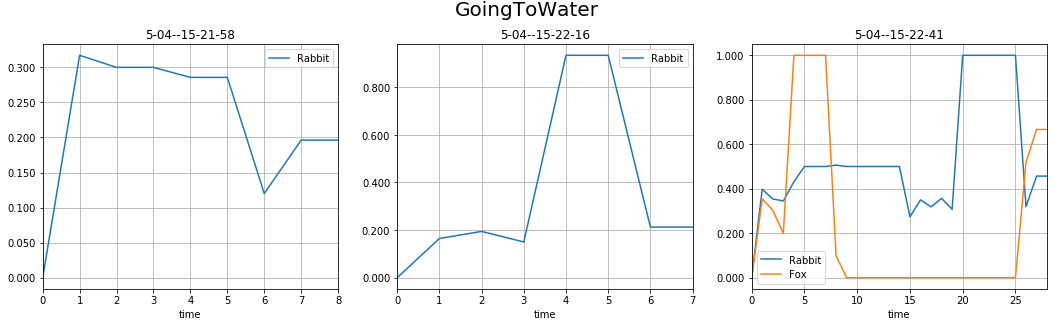

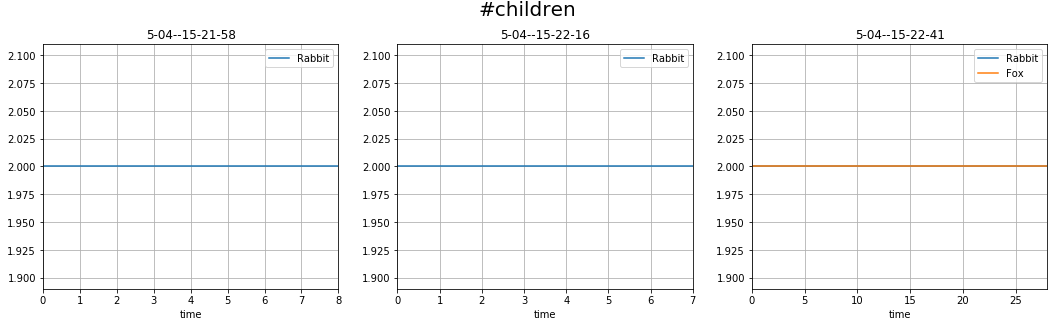

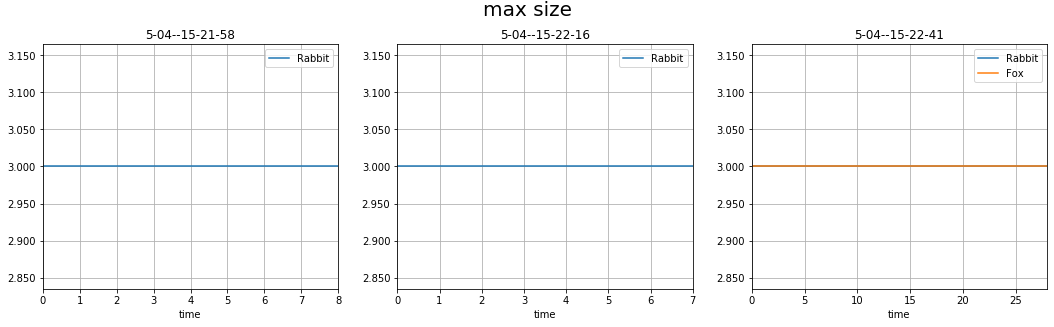

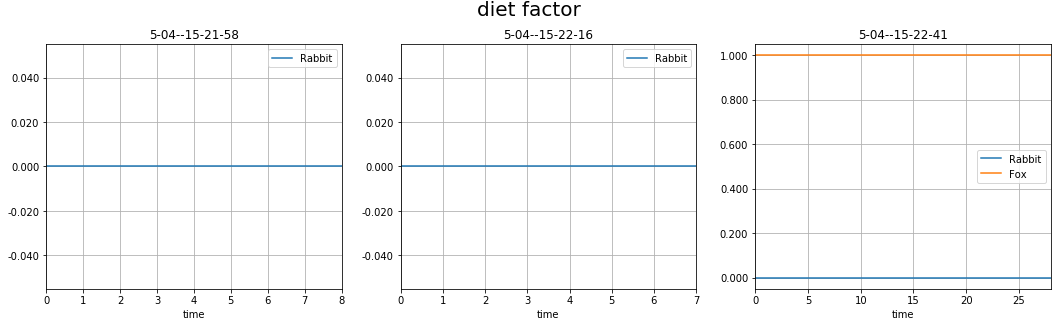

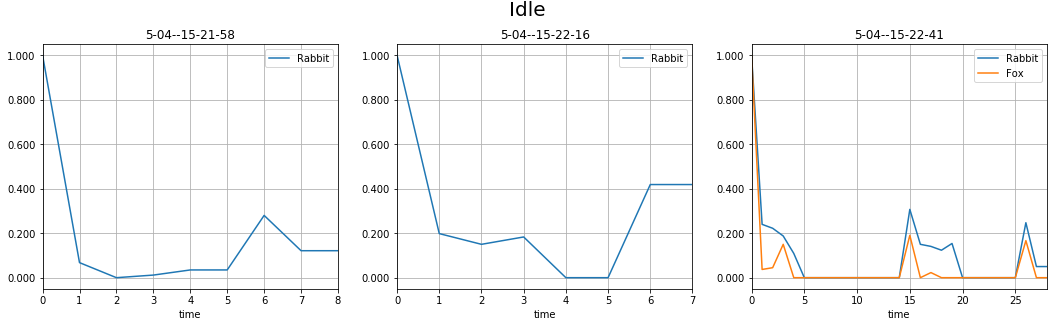

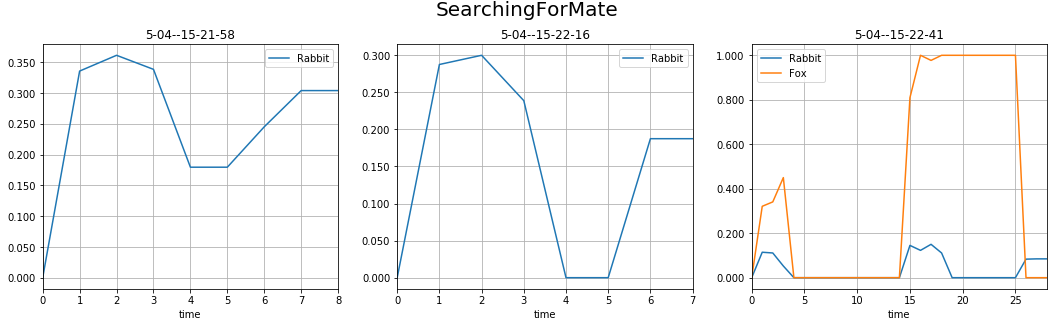

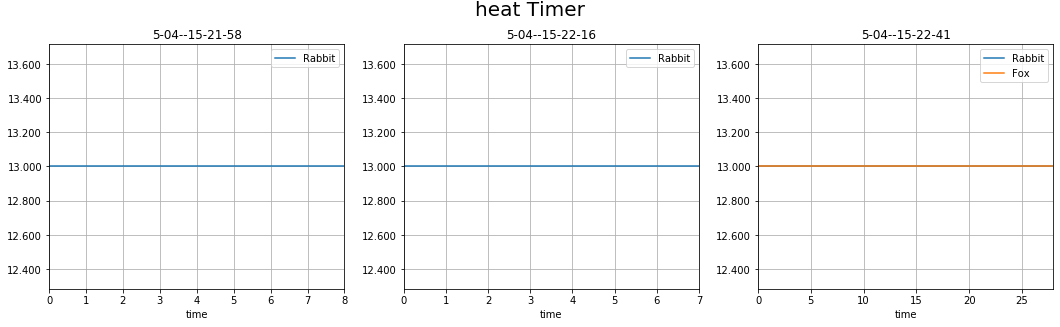

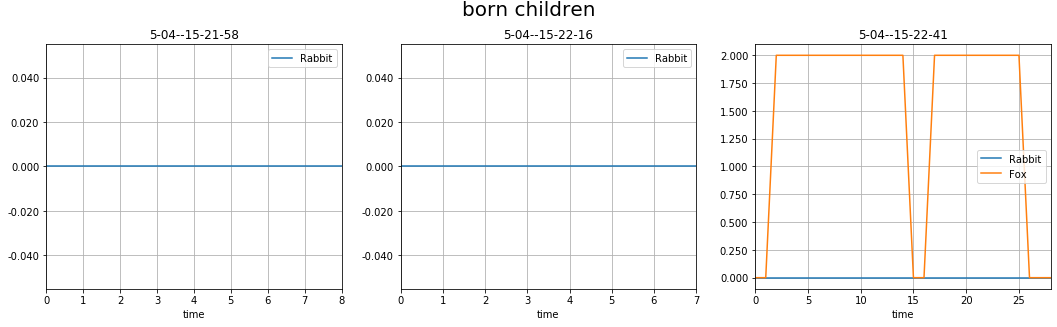

In [7]:
if graphTraits:
    # plot traits grouped by trait and simulation
    # Determine how many plots for each trait
    maxDataPointsPerPlot = int(200/len(dataframes))
    maxDataPoints = 0
    for d in dataframes:
        rows = len(d[0].index)
        if rows > maxDataPoints:
            maxDataPoints = rows

    rest = maxDataPoints
    nbrPlotRows = 0
    while (rest > 0):
        nbrPlotRows += 1
        rest -= maxDataPointsPerPlot

    for t in traits:
        fig, axes = plt.subplots(nbrPlotRows, len(dataframes), figsize = (18,4.5*nbrPlotRows))
        fig.get_axes()[0].annotate(t,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
        plt.subplots_adjust(hspace = 0.3)
        #fig.tight_layout()

        counter = 0
        for df in dataframes:
            length = len(df[0])

            ax = None
            legend = []
            for s in species:
                start = 0
                end = maxDataPointsPerPlot
                rowCounter = 0
                col = s + '-' + t
                # if e.g Rabbit-speed existed in this simulation, then plot it
                if col in df[0].columns:
                    for i in range(0,nbrPlotRows):
                        if (start < length):
                            # different sub axis indexing depending on nbr of simulations / rows
                            subAx = None
                            if nbrPlotRows == 1 and len(dataframes) == 1:
                                subAx = axes
                            elif nbrPlotRows == 1:
                                subAx = axes[counter]
                            elif len(dataframes) == 1:
                                subAx = axes[rowCounter]
                            else:
                                subAx = axes[rowCounter][counter]
                            ax = df[0].iloc[start:end].plot(kind='line', use_index=True, y=col, grid=True, title=df[1], ax=subAx)
                            legend.append(s)
                            ax.set_xlabel("time")
                            ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                            start = end
                            if (end + maxDataPointsPerPlot > length-1):
                                end = length
                            else:
                                end += maxDataPointsPerPlot
                        else: # make subplot blank
                            if nbrPlotRows == 1 and len(dataframes) == 1:
                                axes.axis('off')
                            elif nbrPlotRows == 1:
                                axes[counter].axis('off')
                            elif len(dataframes) == 1:
                                axes[rowCounter].axis('off')
                            else:
                                axes[rowCounter][counter].axis('off')
                        rowCounter += 1
            counter += 1
            # if the the simulation had this trait, then fix legend name
            if len(legend) > 0:
                ax.legend(legend)
        if export:
            fig.savefig(folder + "/" + t, bbox_inches = 'tight')

C:\Users\Bali\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


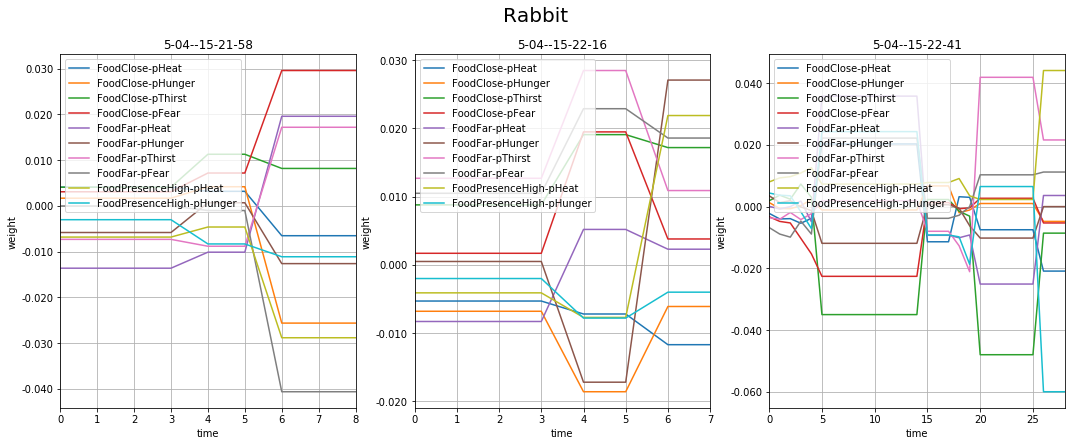

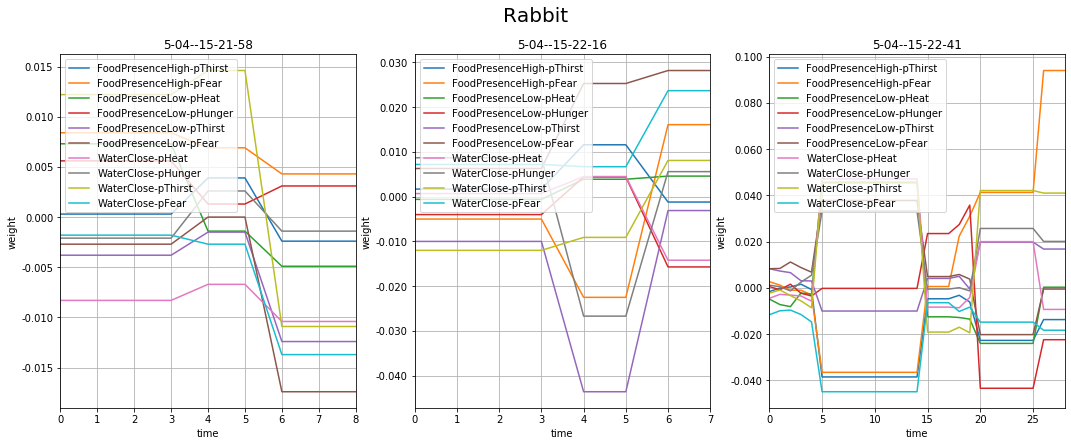

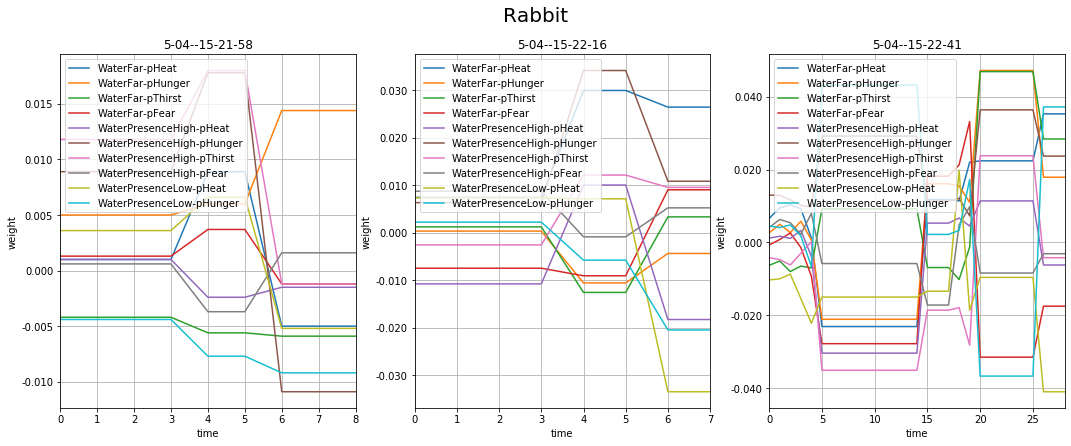

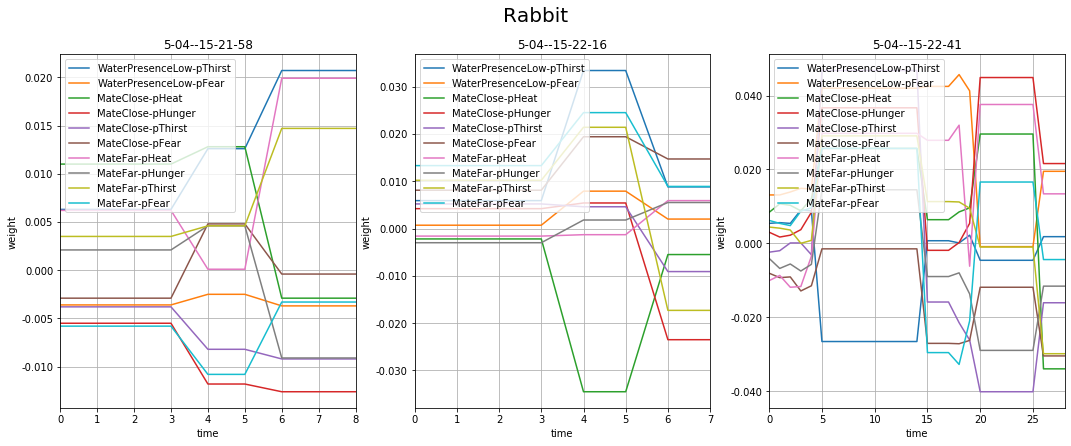

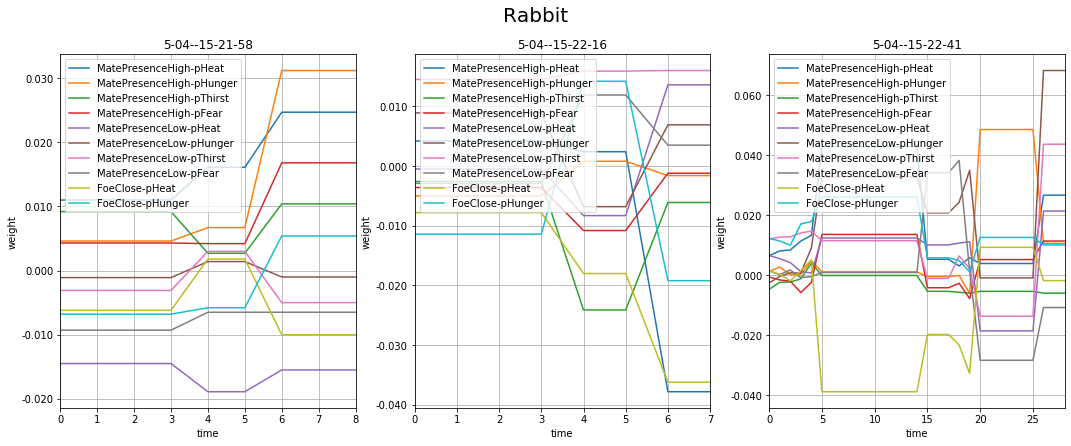

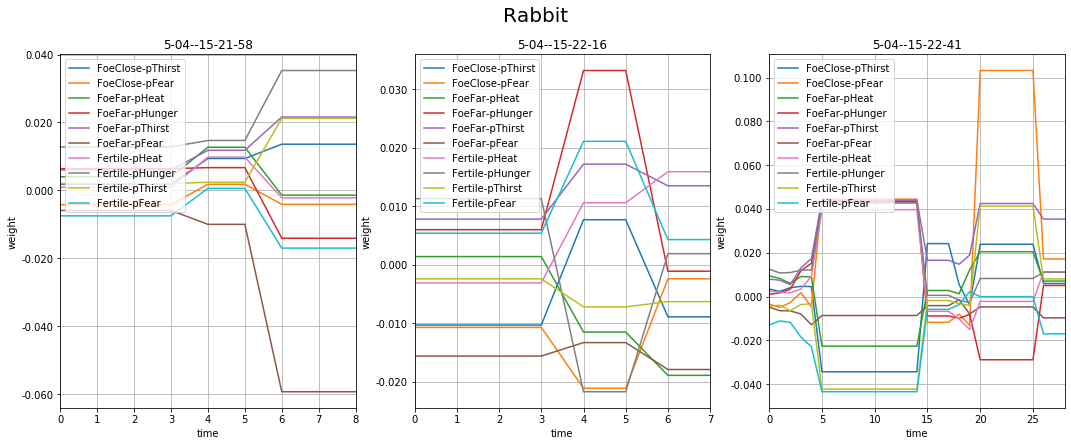

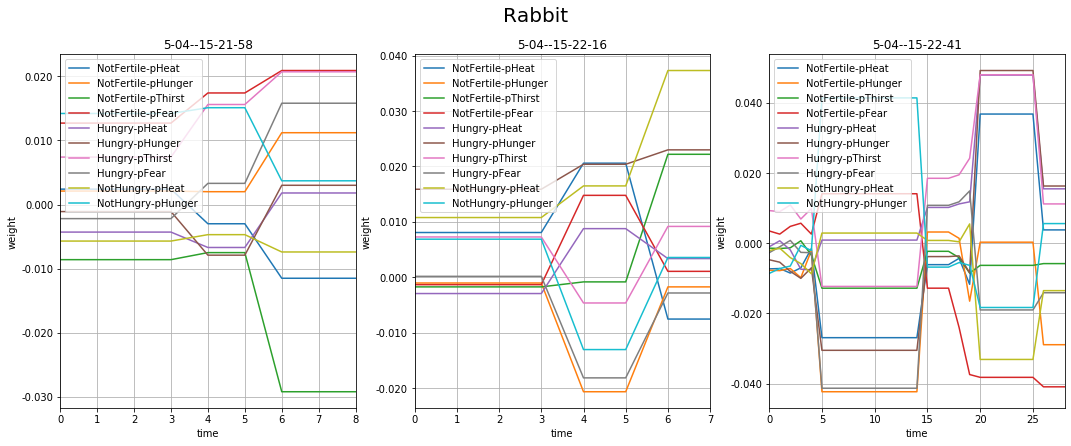

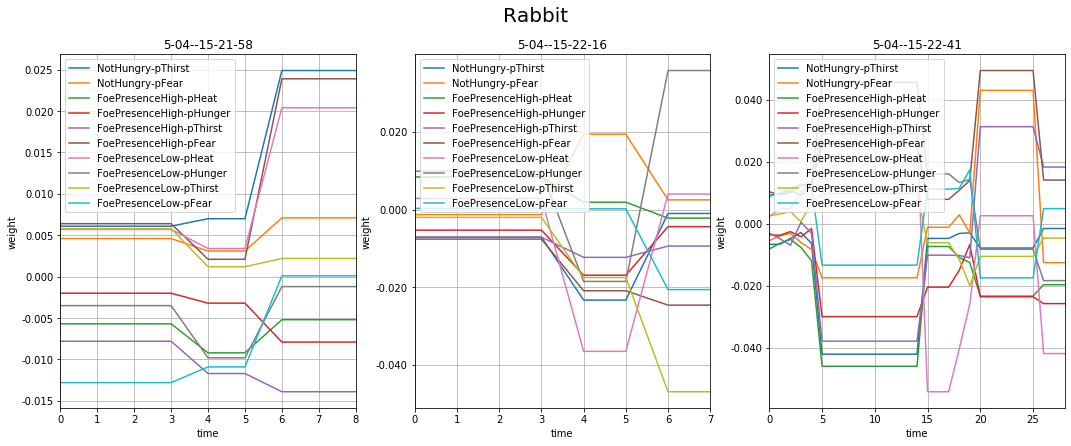

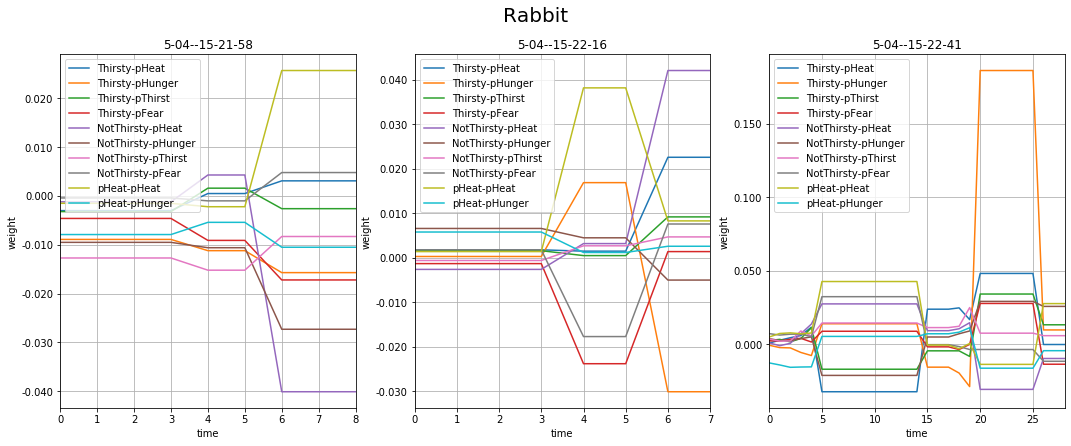

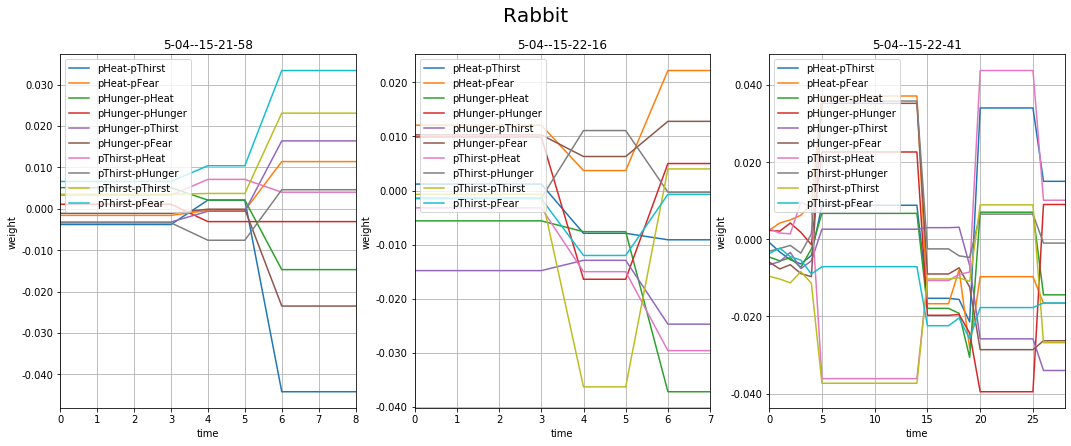

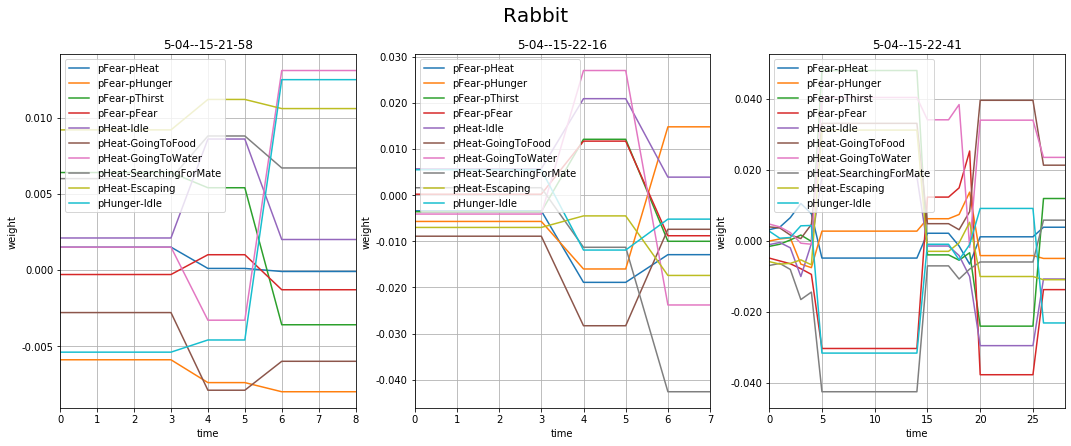

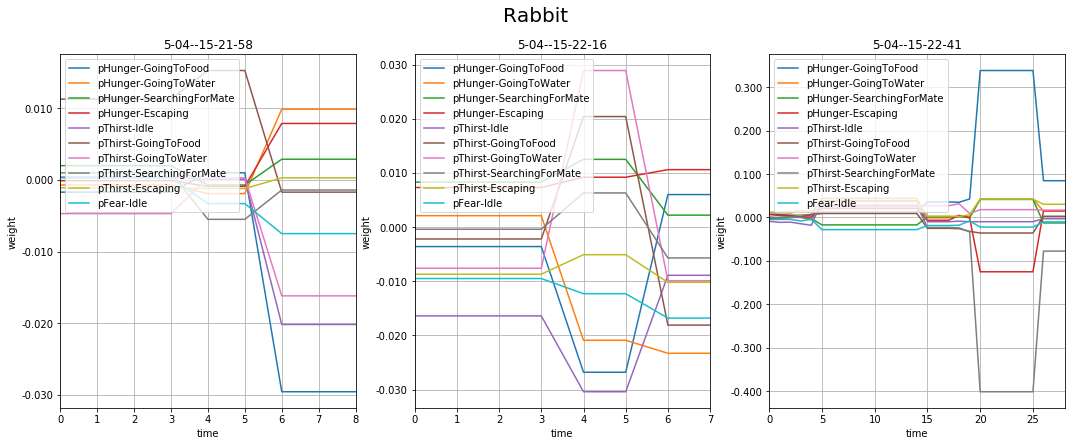

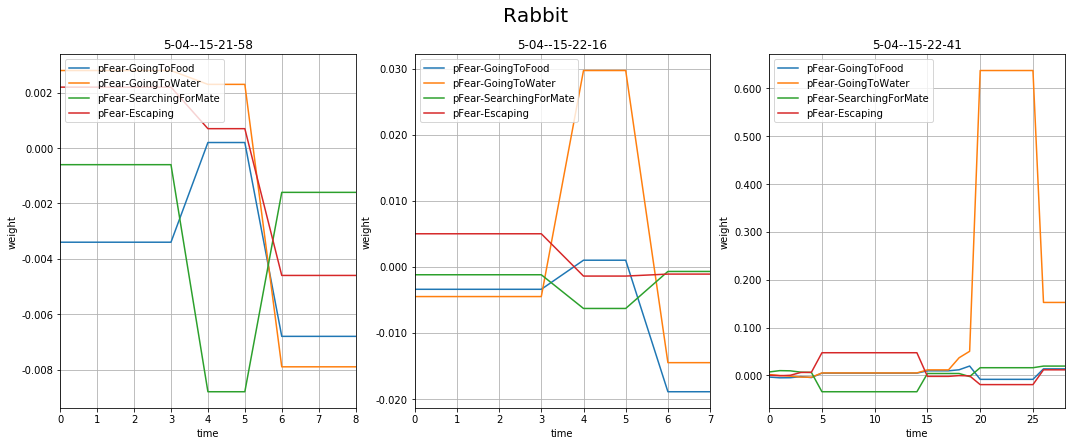

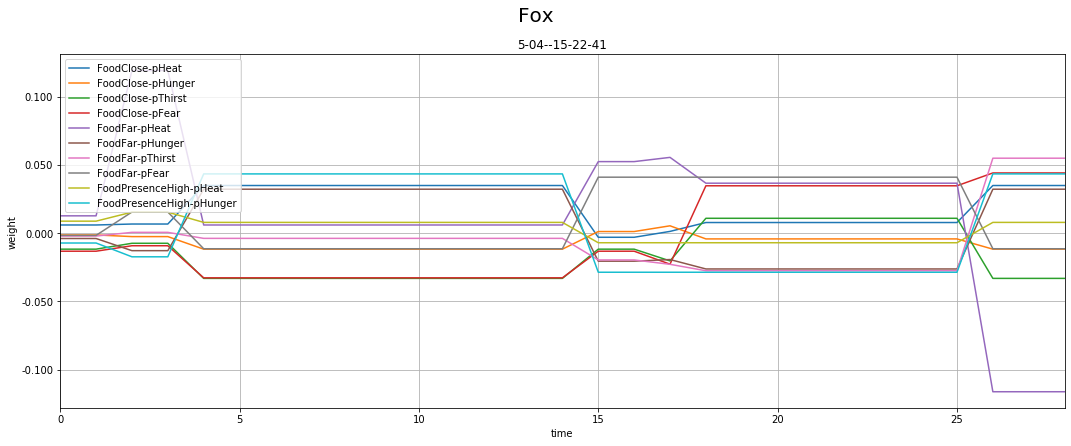

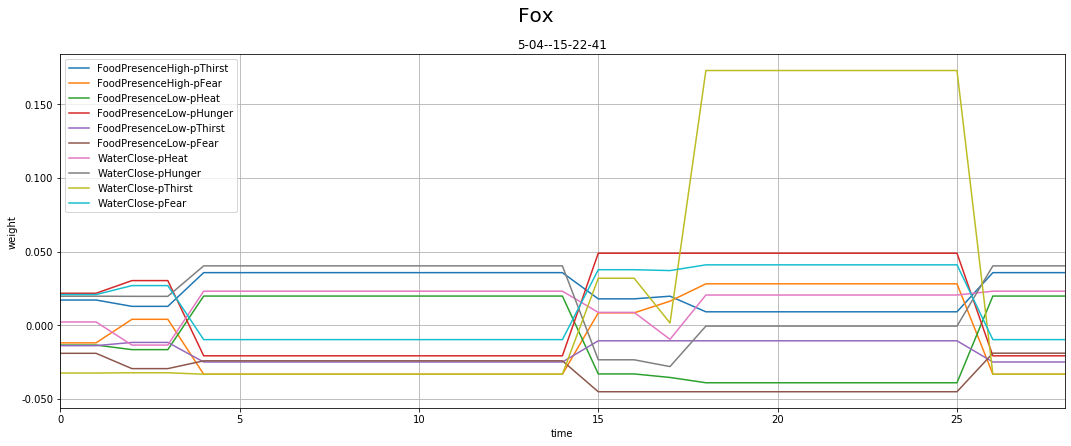

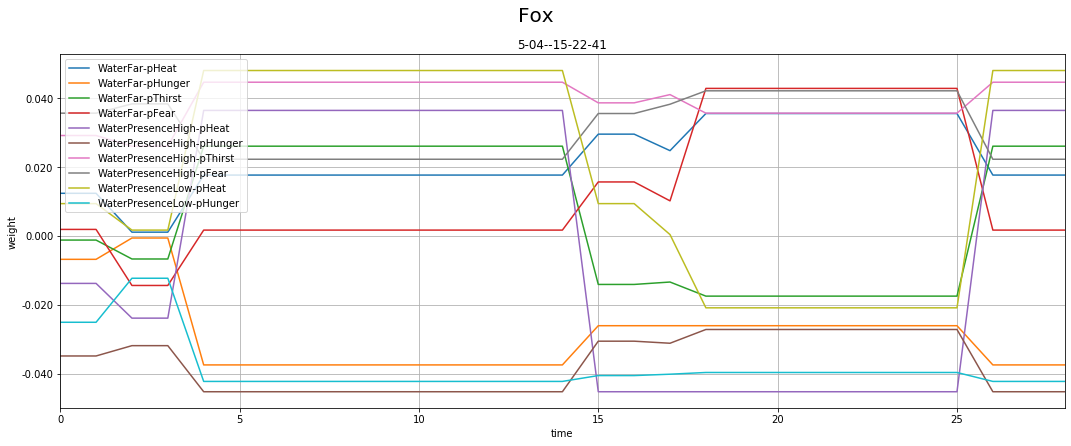

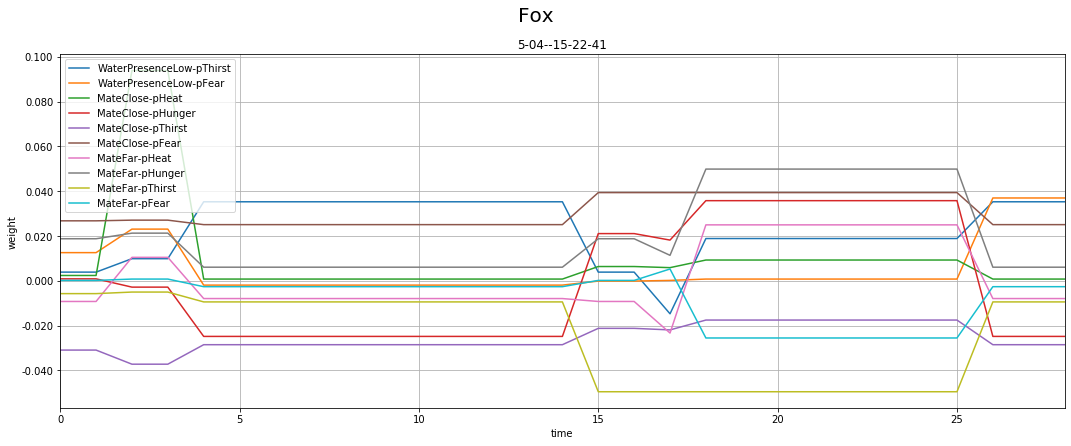

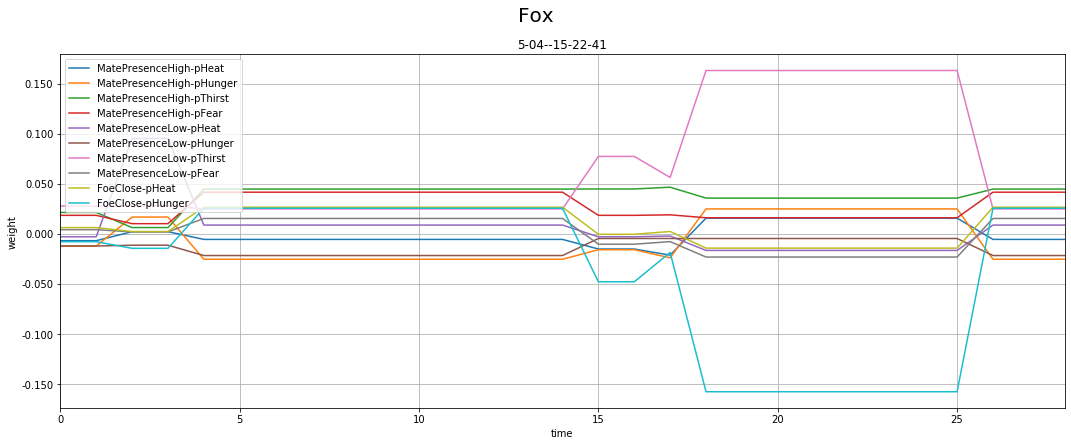

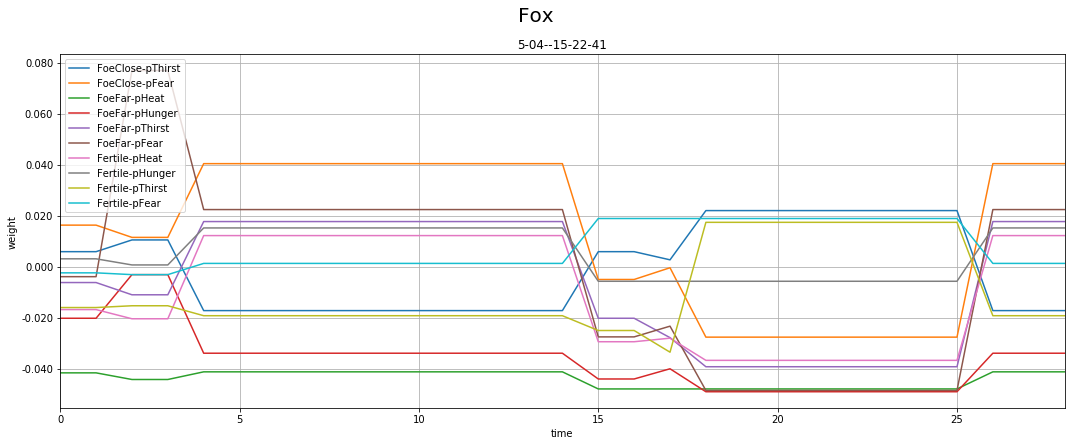

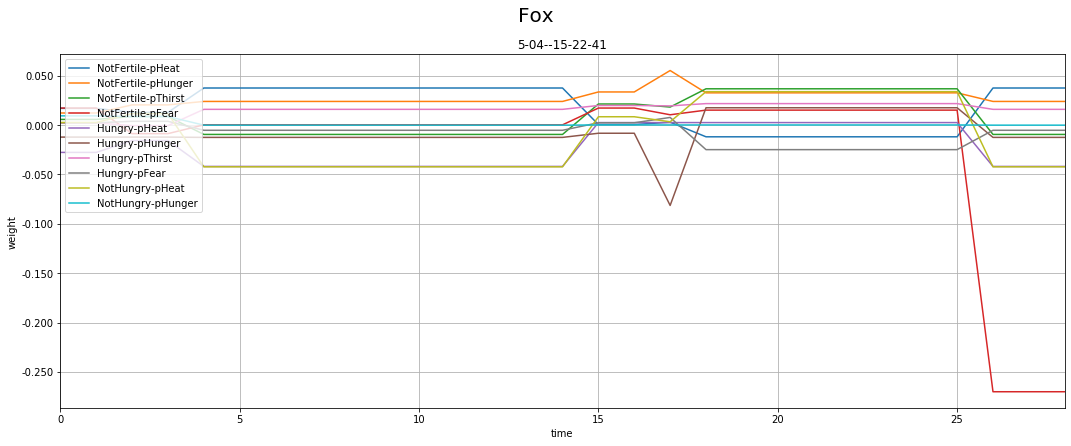

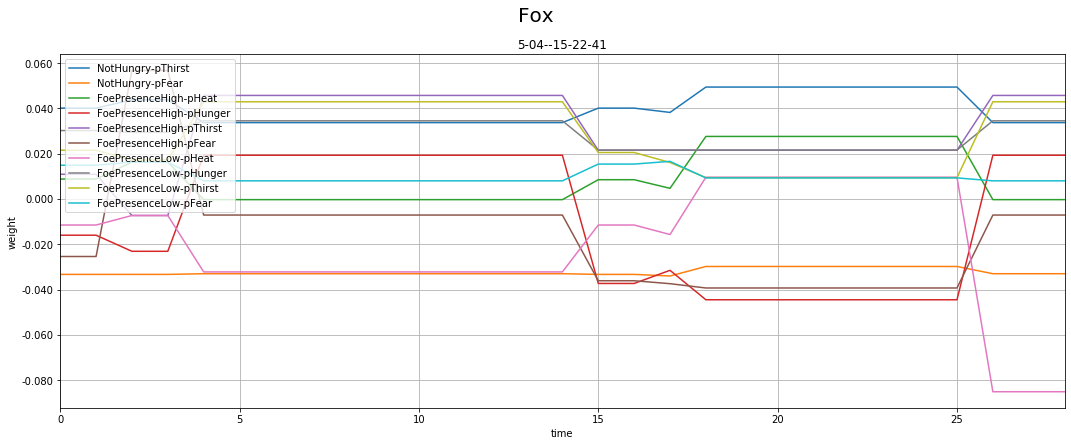

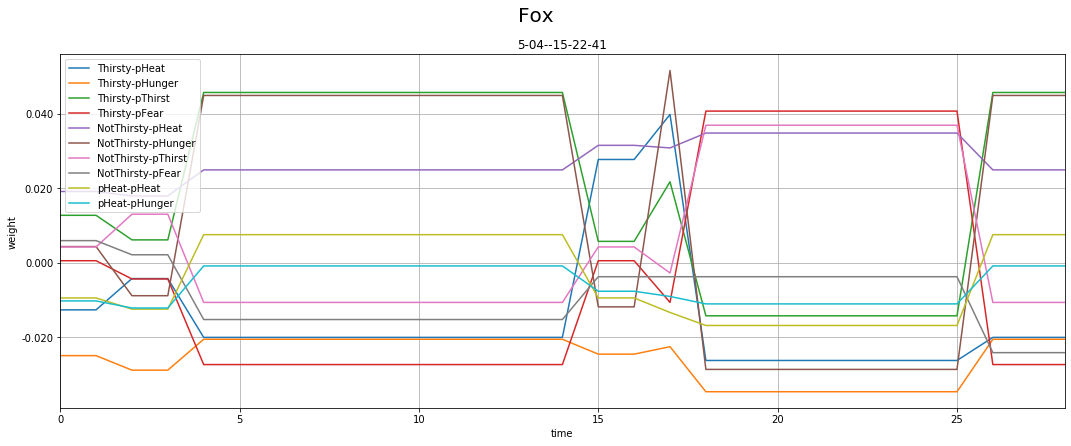

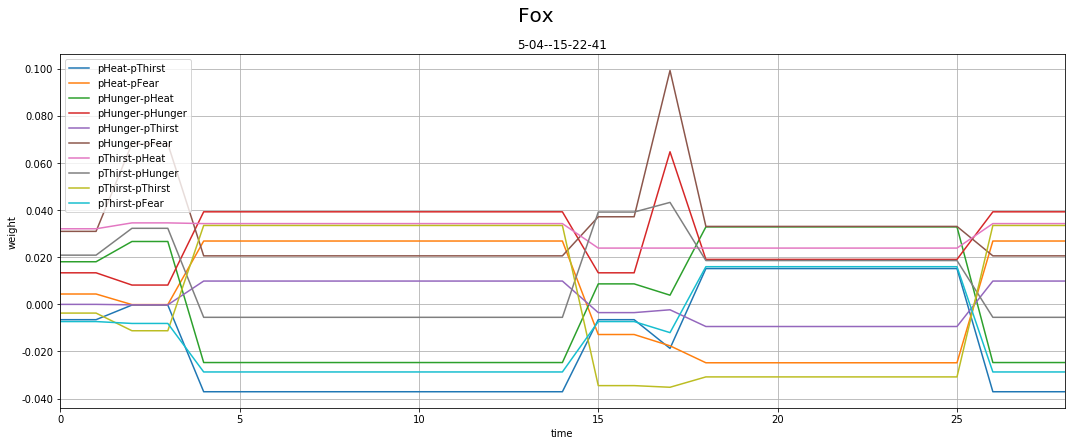

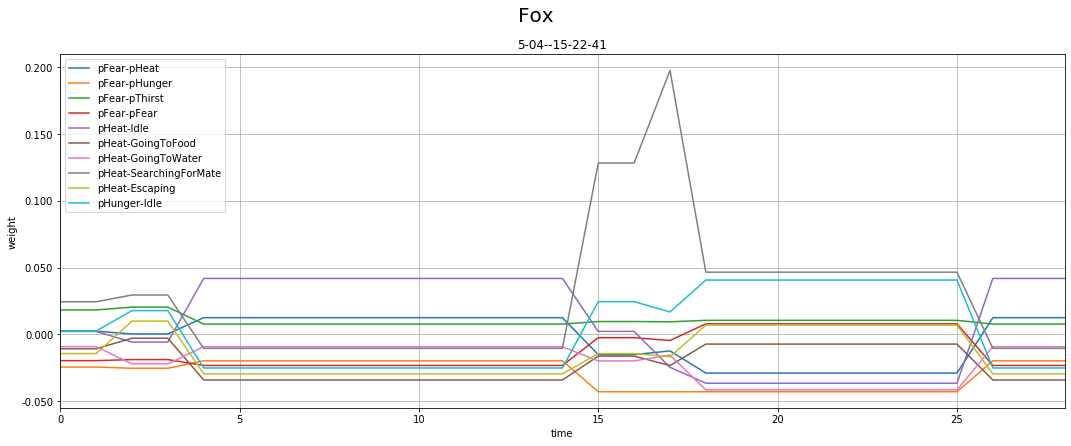

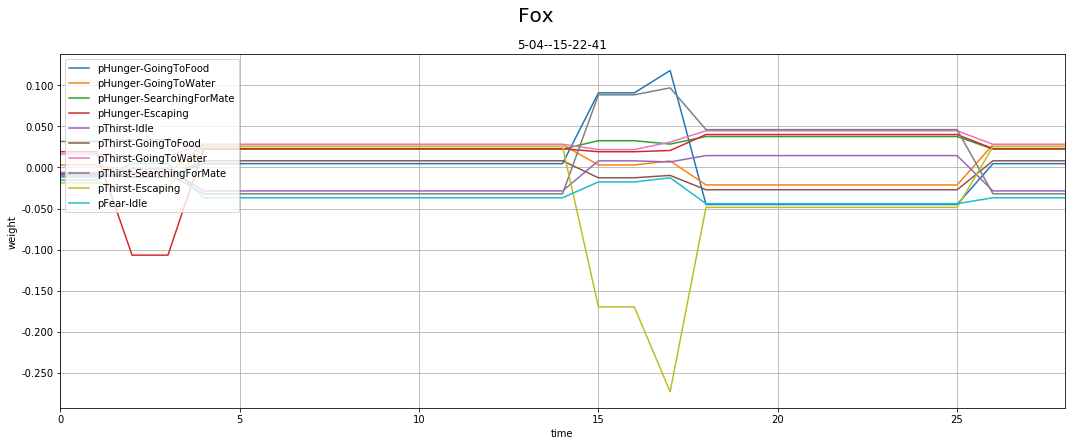

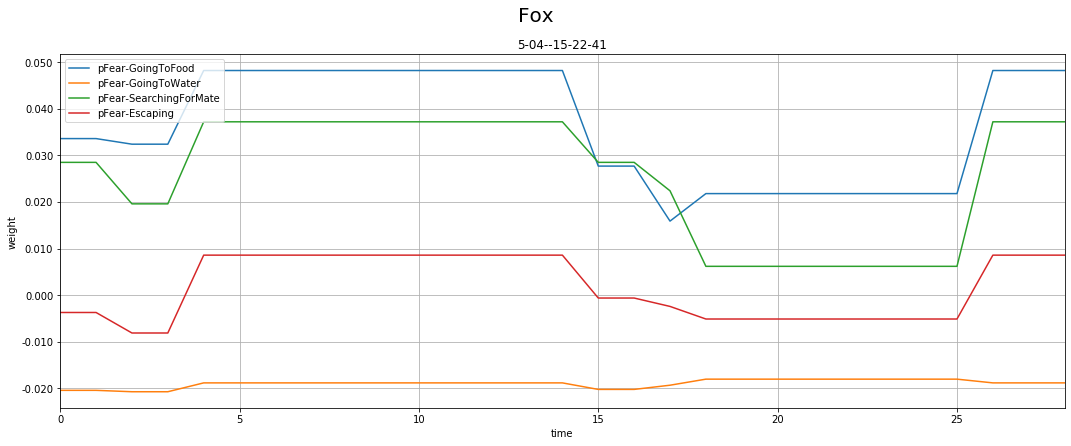

In [8]:

# plot fcm grouped by animal and simulation

#---------------- determine nbr of weights per plot, and how many plots
weightsPerPlot = 10
maxTotalWeights = 0
for d in fcmGraphFrames:
    weights = len(fcmGraphFrames[d][0][0].columns)
    if weights > maxTotalWeights:
        maxTotalWeights = weights
        
rest = maxTotalWeights
nbrWeightPlots = 0
while (rest > 0):
    nbrWeightPlots += 1
    rest -= weightsPerPlot

# -----------------------Determine how many plots for each tuple of weights
maxDataPointsPerPlot = int(20000/len(dataframes))
maxDataPoints = 0
for d in fcmGraphFrames:
    for i in range(0,len(fcmGraphFrames[d])):
        rows = len(fcmGraphFrames[d][i][0].index)
        if rows > maxDataPoints:
            maxDataPoints = rows
        
rest = maxDataPoints
nbrPlotRows = 0
while (rest > 0):
    nbrPlotRows += 1
    rest -= maxDataPointsPerPlot
        
for s in species:
    weightIndex = 0
    weightCounter = 0
    for weightPlot in range(0, nbrWeightPlots):
        
        # get the weights for this plot
        weights = []
        for index in range(weightIndex,weightIndex+weightsPerPlot):
            if index < len(fcmGraphFrames[s][0][0].columns):
                weight = fcmGraphFrames[s][0][0].columns[index]
                weights.append(weight)
        
        fig, axes = plt.subplots(nbrPlotRows, len(fcmGraphFrames[s]), figsize = (18,6.5*nbrPlotRows))
        fig.get_axes()[0].annotate(s,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
        plt.subplots_adjust(hspace = 0.3)
        #fig.tight_layout()

        counter = 0
        for df in fcmGraphFrames[s]:
            length = len(df[0])

            ax = None
            legend = []
            start = 0
            end = maxDataPointsPerPlot
            rowCounter = 0
            # if e.g Rabbit-speed existed in this simulation, then plot it
            for i in range(0,nbrPlotRows):
                if (start < length):
                    # different sub axis indexing depending on nbr of simulations / rows
                    subAx = None
                    if nbrPlotRows == 1 and len(fcmGraphFrames[s]) == 1:
                        subAx = axes
                    elif nbrPlotRows == 1:
                        subAx = axes[counter]
                    elif len(fcmGraphFrames[s]) == 1:
                        subAx = axes[rowCounter]
                    else:
                        subAx = axes[rowCounter][counter]
                    for col in weights:
                        ax = df[0].iloc[start:end].plot(kind='line', use_index=True, y=col, grid=True, title=df[1], ax=subAx)
                        
                    legend.append(col)
                    if len(legend) > 0:
                        ax.legend(legend)
                        ax.legend(fancybox=True,framealpha=0.3)
                        ax.legend(loc='upper left')
                    ax.set_xlabel("time")
                    ax.set_ylabel("weight")
                    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                    start = end
                    if (end + maxDataPointsPerPlot > length-1):
                        end = length
                    else:
                        end += maxDataPointsPerPlot
                else: # make subplot blank
                    if nbrPlotRows == 1 and len(fcmGraphFrames[s]) == 1:
                        axes.axis('off')
                    elif nbrPlotRows == 1:
                        axes[counter].axis('off')
                    elif len(fcmGraphFrames[s]) == 1:
                        axes[rowCounter].axis('off')
                    else:
                        axes[rowCounter][counter].axis('off') 
                        
                rowCounter += 1
            counter += 1
            # if the the simulation had this trait, then fix legend name
                #ax.legend(bbox_to_anchor=(0.4,1.65))
        weightIndex += weightsPerPlot
        if export:
            fig.savefig(fcmGraphFolder + "/" + str(s) + " " + str(weightCounter), bbox_inches = 'tight')
        weightCounter +=1

In [9]:
"""
# plot fcm
for s in species:
    
    fig, axes = plt.subplots(1,len(dataframes), figsize = (18,6))
    #fig.get_axes()[0].annotate(s,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
    counter = 0
    for fcm in fcmJsons:

        if fcm[2] == s:
            G = nx.DiGraph(directed=True)
            for entry in fcm[0]['weights']:
                G.add_weighted_edges_from([(entry['from'], entry['to'], entry['weight'])])

            edge_labels=dict([((u,v,),d['weight'])
                             for u,v,d in G.edges(data=True)])

            pos=nx.planar_layout(G)
            nx.draw_networkx(G, pos, arrows=True, arrowsize=20, with_labels=True, node_size=600, font_color='black', ax = axes[counter], title = fcm[1])
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax = axes[counter], title = fcm[1])
            axes[counter].set_xticklabels([])
            axes[counter].set_yticklabels([])
            axes[counter].set_title(fcm[1])
            counter += 1
    fig.suptitle(s, y = 0.97, size = 20)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.87)
    if export:
        fig.savefig(folder + "/" + s)
"""

'\n# plot fcm\nfor s in species:\n    \n    fig, axes = plt.subplots(1,len(dataframes), figsize = (18,6))\n    #fig.get_axes()[0].annotate(s,(0.5,0.95),xycoords=\'figure fraction\', ha=\'center\',fontsize=20)\n    counter = 0\n    for fcm in fcmJsons:\n\n        if fcm[2] == s:\n            G = nx.DiGraph(directed=True)\n            for entry in fcm[0][\'weights\']:\n                G.add_weighted_edges_from([(entry[\'from\'], entry[\'to\'], entry[\'weight\'])])\n\n            edge_labels=dict([((u,v,),d[\'weight\'])\n                             for u,v,d in G.edges(data=True)])\n\n            pos=nx.planar_layout(G)\n            nx.draw_networkx(G, pos, arrows=True, arrowsize=20, with_labels=True, node_size=600, font_color=\'black\', ax = axes[counter], title = fcm[1])\n            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, ax = axes[counter], title = fcm[1])\n            axes[counter].set_xticklabels([])\n            axes[counter].set_yticklabels([])

C:\Users\Bali\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


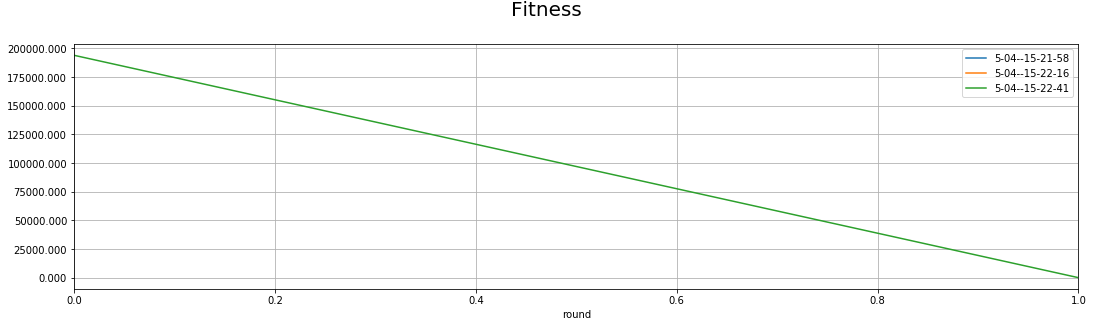

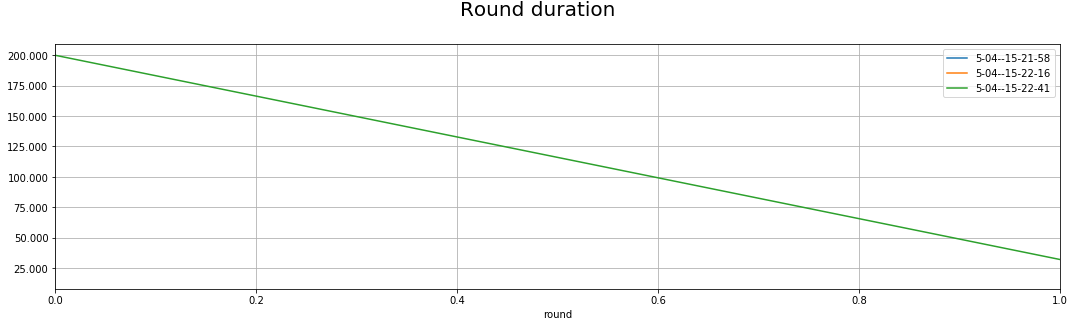

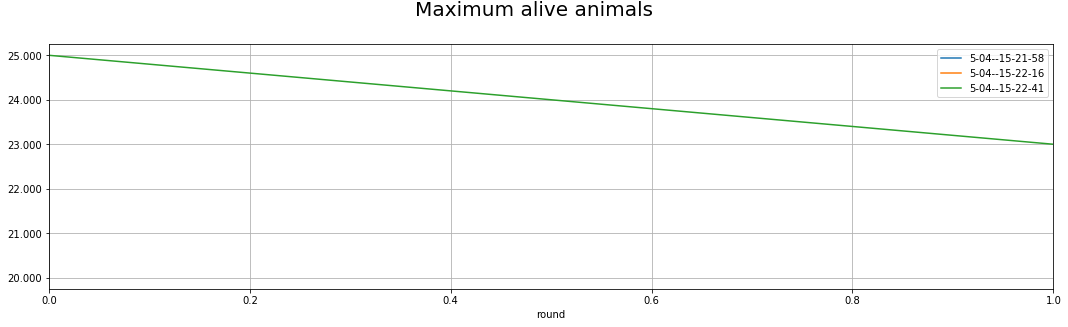

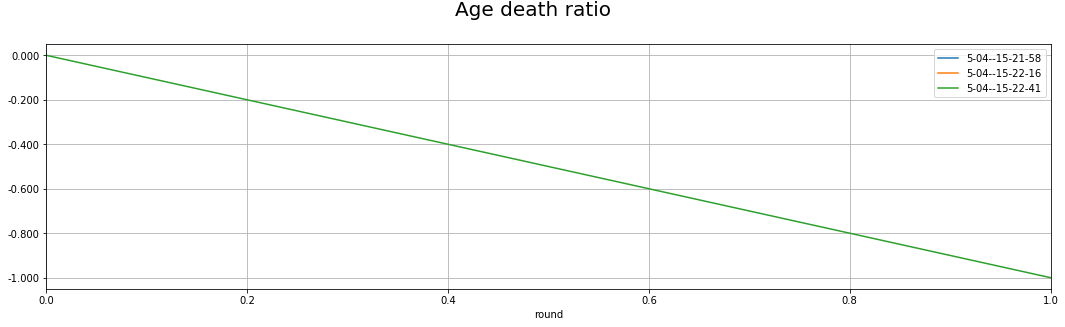

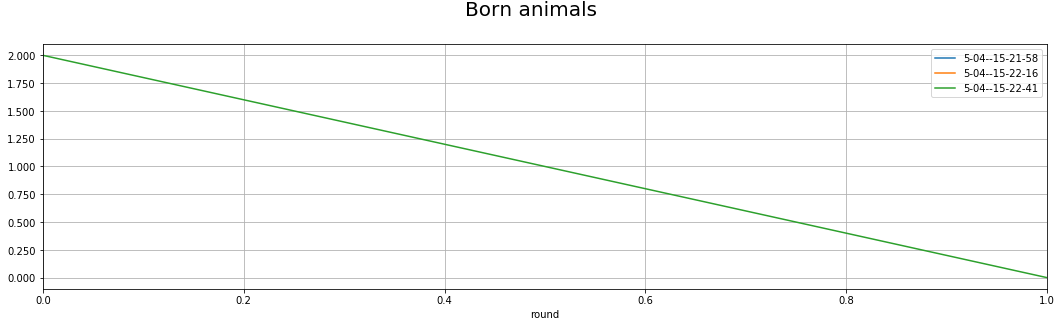

In [10]:
if graphRounds:
    # plot round stats
    # Determine how many plots for each trait
    maxDataPointsPerPlot = 200
    maxDataPoints = 0
    for d in roundFrames:
        rows = len(d[0].index)
        if rows > maxDataPoints:
            maxDataPoints = rows

    rest = maxDataPoints
    nbrPlotRows = 0
    while (rest > 0):
        nbrPlotRows += 1
        rest -= maxDataPointsPerPlot

    for col in roundFrames[0][0].columns:
        fig, axes = plt.subplots(nbrPlotRows, 1, figsize = (18,4.5*nbrPlotRows))
        fig.get_axes()[0].annotate(col,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
        plt.subplots_adjust(hspace = 0.3)
        #fig.tight_layout()

        legend = []
        for df in roundFrames:
            length = len(df[0])

            ax = None
            start = 0
            end = maxDataPointsPerPlot
            rowCounter = 0
            for i in range(0,nbrPlotRows):
                if (start < length):
                    # different sub axis indexing depending on nbr of simulations / rows
                    subAx = None
                    if nbrPlotRows == 1:
                        subAx = axes
                    else:
                        subAx = axes[rowCounter]
                    ax = df[0].iloc[start:end].plot(kind='line', use_index=True, y=col, grid=True, ax=subAx)
                    legend.append(df[1])
                    ax.set_xlabel("round")
                    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                    start = end
                    if (end + maxDataPointsPerPlot > length-1):
                        end = length
                    else:
                        end += maxDataPointsPerPlot
                rowCounter += 1
            # if the the simulation had this trait, then fix legend name
        if len(legend) > 0:
            ax.legend(legend)
        if export:
            fig.savefig(roundFolder + "/" + col, bbox_inches = 'tight')


5
['Idle', 'GoingToFood', 'GoingToWater', 'SearchingForMate', 'Escaping']
['Idle', 'GoingToFood', 'GoingToWater', 'SearchingForMate', 'Escaping']


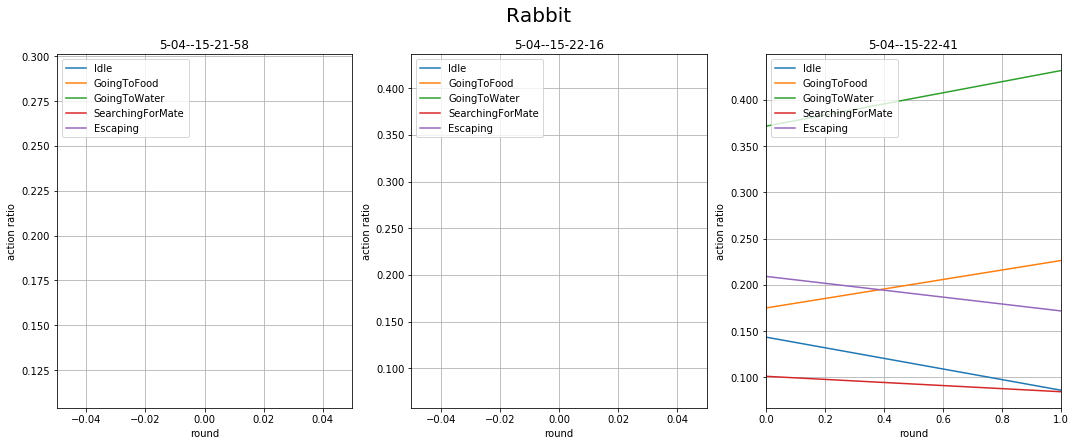

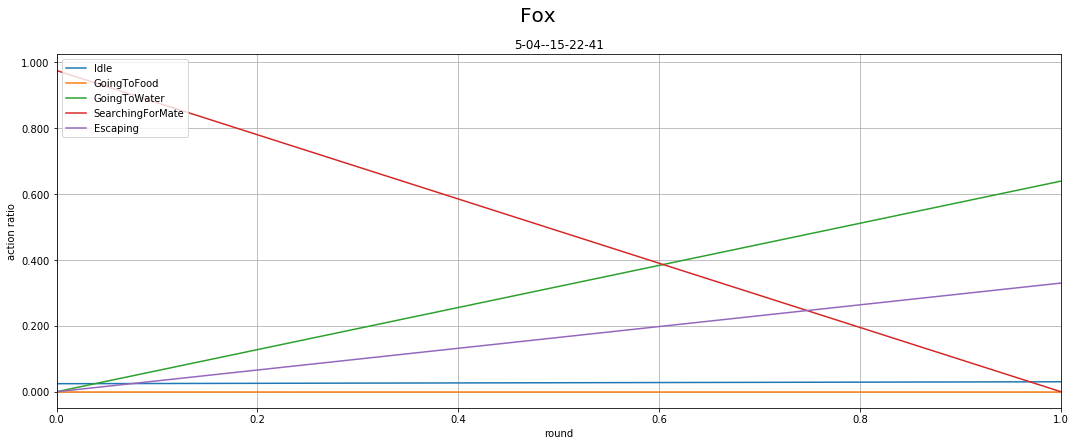

In [16]:

# plot fcm grouped by animal and simulation

#---------------- determine nbr of actions per plot, and how many plots
cols = ((actionFrames[next(iter(species))])[0][0]).columns
nbrOfActions=len(cols)


# -----------------------Determine how many plots for each simulation
maxDataPointsPerPlot = int(20000/len(dataframes))
maxDataPoints = 0
for d in actionFrames:
    for i in range(0,len(actionFrames[d])):
        rows = len(actionFrames[d][i][0].index)
        if rows > maxDataPoints:
            maxDataPoints = rows
        
rest = maxDataPoints
nbrPlotRows = 0
while (rest > 0):
    nbrPlotRows += 1
    rest -= maxDataPointsPerPlot
        
for s in species:
    actionIndex = 0
    actionCounter = 0
    for actionPlot in range(0, 1):
        
        # get the weights for this plot
        actions = []
        for index in range(actionIndex,actionIndex+nbrOfActions):
            if index < len(actionFrames[s][0][0].columns):
                action = actionFrames[s][0][0].columns[index]
                actions.append(action)
        
        fig, axes = plt.subplots(nbrPlotRows, len(actionFrames[s]), figsize = (18,6.5*nbrPlotRows))
        fig.get_axes()[0].annotate(s,(0.5,0.95),xycoords='figure fraction', ha='center',fontsize=20)
        plt.subplots_adjust(hspace = 0.3)
        #fig.tight_layout()

        counter = 0
        for df in actionFrames[s]:
            length = len(df[0])

            ax = None
            legend = []
            start = 0
            end = maxDataPointsPerPlot
            rowCounter = 0
            # if e.g Rabbit-speed existed in this simulation, then plot it
            for i in range(0,nbrPlotRows):
                if (start < length):
                    # different sub axis indexing depending on nbr of simulations / rows
                    subAx = None
                    if nbrPlotRows == 1 and len(actionFrames[s]) == 1:
                        subAx = axes
                    elif nbrPlotRows == 1:
                        subAx = axes[counter]
                    elif len(actionFrames[s]) == 1:
                        subAx = axes[rowCounter]
                    else:
                        subAx = axes[rowCounter][counter]
                    for col in actions:
                        ax = df[0].iloc[start:end].plot(kind='line', use_index=True, y=col, grid=True, title=df[1], ax=subAx)
                        
                        legend.append(col)
                        if len(legend) > 0:
                            ax.legend(legend)
                            ax.legend(fancybox=True,framealpha=0.3)
                            ax.legend(loc='upper left')
                    ax.set_xlabel("round")
                    ax.set_ylabel("action ratio")
                    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                    start = end
                    if (end + maxDataPointsPerPlot > length-1):
                        end = length
                    else:
                        end += maxDataPointsPerPlot
                else: # make subplot blank
                    if nbrPlotRows == 1 and len(actionFrames[s]) == 1:
                        axes.axis('off')
                    elif nbrPlotRows == 1:
                        axes[counter].axis('off')
                    elif len(fcmGraphFrames[s]) == 1:
                        axes[rowCounter].axis('off')
                    else:
                        axes[rowCounter][counter].axis('off') 
                        
                rowCounter += 1
            counter += 1
            # if the the simulation had this trait, then fix legend name
                #ax.legend(bbox_to_anchor=(0.4,1.65))
        actionIndex += nbrOfActions
        if export:
            fig.savefig(actionFolder + "/" + str(s), bbox_inches = 'tight')
        actionCounter +=1